<a href="https://colab.research.google.com/github/amarsinghen/amazon-reviews-sentiment-analysis/blob/master/amazon_reviews_sentiment_analysis_lstm_basic_datapreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
import zipfile
import pandas as pd
import numpy as np
import bz2
import gc
import chardet
import re
import os
import pickle
import gzip
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns
import matplotlib.pyplot as plt 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, LSTM
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

## Loading raw data from kaggle

In [4]:
# Downloading the data from kaggle for first time, and 
# then saving to google drive for future uses. It is faster this way
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bittlingmayer/amazonreviews

100% 491M/493M [00:04<00:00, 152MB/s]
100% 493M/493M [00:04<00:00, 121MB/s]


In [5]:
import zipfile
local_zip = ['amazonreviews.zip']
for i in range(len(local_zip)):
    zip_ref = zipfile.ZipFile(local_zip[i], 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

In [6]:
train_file = bz2.BZ2File('/tmp/train.ft.txt.bz2')
test_file = bz2.BZ2File('/tmp/test.ft.txt.bz2')

In [7]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [8]:
print(len(train_file_lines))
print(train_file_lines[:5])
print(len(test_file_lines))
print(test_file_lines[:5])

3600000
[b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n", b'__label__2 Amazing

## Text Data Pre-Processing

In [9]:
# Convert from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [10]:
print(len(train_file_lines))
print(train_file_lines[:5])
print(len(test_file_lines))
print(test_file_lines[:5])

3600000
['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n", '__label__2 Amazing!: 

In [11]:
# Creating and extracting labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

# replacg urls                                                     
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

# Removing stopwords


In [12]:
print(len(train_sentences))
print(train_sentences[:5])
print(len(test_sentences))
print(test_sentences[:5])

3600000
['stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^', "the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.", 'amazing!: this soundtrack is my favorite music 

## Tokenization

In [13]:
vocab_size = 20000
embedding_dim = 100
max_length = 100
trunc_type = 'post'
oov_tok="<oov>"

In [14]:
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [15]:
sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = sequence.pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

In [16]:
training_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     1,    75,    12,     2,   611,  6396,     9,
         177,   486,    14,   365,     7,  6072,     2,     1,    11,
          61,   439,    28,    70,     4,    40,  1836,     7,    75,
           6,   136,    73,   679, 16704,   146,   120,     4,    21,
         525,     2,   146,     1,  1871,    17,    41,     8,    29,
           8,     2,   598,     4,    21,   133,   525,     7,    45,
           2,    89,   120,     7,  6683,   241,    38,  5110,     1,
           3,   423,     5, 16762,   852,    18,  8996,  3029,     3,
        4339, 19158,     7,    40,  5210,   208,    73,  2729,     6,
         337], dtype=int32)

In [17]:
tokenized_test = tokenizer.texts_to_sequences(test_sentences)
testing_padded = sequence.pad_sequences(tokenized_test, maxlen=max_length)
testing_padded[0]

array([   45,    25,     8,     2,    31,  1918,     8,    80,  1958,
           4,    21,  1031,     6,     9,    96,    12,   139,     3,
           4,   128,    82,     7,    52,   111,    11,     5,    33,
        2063,     7,   210,    44,   230,    92,     5,   129,  2063,
          37,     1,    34,  2305,    11,     2,  2275,     9,    96,
          37,     1,   155,  1032,    24,     1,     1,     3,   647,
          37,  1529,    25,     8,  6336,  2462,  4236,     9,    10,
           5,  3889, 12034,    96,    11,    22,    20,   183,    98,
         123,   130,     7,   221,    10,    37,   862,    44,  2694,
           4,   236,     9,    55,   616,   430,   577,   460,   135,
        1777,  1352,  2199,   499,    25,   163,    73,    14,    13,
         911], dtype=int32)

In [18]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

In [19]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'') for i in text])
print(decode_review(training_padded[1]))
print(train_sentences[1])


  the best soundtrack ever to anything i'm reading a lot of reviews saying that this is the best <oov> <oov> and i figured that i'd write a review to disagree a bit this in my <oov> is <oov> <oov> ultimate masterpiece the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny
the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.


## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_padded, train_labels, test_size=0.20, shuffle = True)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
batch_size = 2048
epochs = 10
l2_factor = 0.0001
learning_rate = 0.001

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, kernel_regularizer=l2(l2_factor), bias_regularizer=l2(l2_factor), kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10), return_sequences=True)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, kernel_regularizer=l2(l2_factor), bias_regularizer=l2(l2_factor), kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10))),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 512)          731136    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [ ]:
weight_path="/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07232020_1.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=callbacks, workers=4)

Epoch 1/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1692 - acc: 0.9399
Epoch 00002: val_loss improved from 0.18967 to 0.16057, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07232020_1.hdf5
1407/1407 [==============================] - 888s 631ms/step - loss: 0.1692 - acc: 0.9399 - val_loss: 0.1606 - val_acc: 0.9421
Epoch 3/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1525 - acc: 0.9460
Epoch 00003: val_loss improved from 0.16057 to 0.15537, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07232020_1.hdf5
1407/1407 [==============================] - 888s 631ms/step - loss: 0.1525 - acc: 0.9460 - val_loss: 0.1554 - val_acc: 0.9433
Epoch 4/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1422 - acc: 0.9502
Epoch 00004: val_loss improved from 0.15537 to 0.15515, saving model to /content/drive/My Drive/kaggle/amazon-reviews-sentiment-analy

**RUN 2**
Epoch 1/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2841 - acc: 0.8771
Epoch 00001: val_loss improved from inf to 0.22664, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.2841 - acc: 0.8771 - val_loss: 0.2266 - val_acc: 0.9107
Epoch 2/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2206 - acc: 0.9143
Epoch 00002: val_loss improved from 0.22664 to 0.21347, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 177ms/step - loss: 0.2206 - acc: 0.9143 - val_loss: 0.2135 - val_acc: 0.9161
Epoch 3/10
1407/1407 [==============================] - ETA: 0s - loss: 0.2078 - acc: 0.9195
Epoch 00003: val_loss improved from 0.21347 to 0.20356, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.2078 - acc: 0.9195 - val_loss: 0.2036 - val_acc: 0.9197
Epoch 4/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1965 - acc: 0.9244
Epoch 00004: val_loss improved from 0.20356 to 0.19252, saving model to early_weights.hdf5
1407/1407 [==============================] - 252s 179ms/step - loss: 0.1965 - acc: 0.9244 - val_loss: 0.1925 - val_acc: 0.9250
Epoch 5/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1840 - acc: 0.9299
Epoch 00005: val_loss improved from 0.19252 to 0.18486, saving model to early_weights.hdf5
1407/1407 [==============================] - 253s 179ms/step - loss: 0.1840 - acc: 0.9299 - val_loss: 0.1849 - val_acc: 0.9288
Epoch 6/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1743 - acc: 0.9343
Epoch 00006: val_loss improved from 0.18486 to 0.17907, saving model to early_weights.hdf5
1407/1407 [==============================] - 252s 179ms/step - loss: 0.1743 - acc: 0.9343 - val_loss: 0.1791 - val_acc: 0.9321
Epoch 7/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1669 - acc: 0.9375
Epoch 00007: val_loss improved from 0.17907 to 0.17276, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.1669 - acc: 0.9375 - val_loss: 0.1728 - val_acc: 0.9343
Epoch 8/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1614 - acc: 0.9400
Epoch 00008: val_loss improved from 0.17276 to 0.17045, saving model to early_weights.hdf5
1407/1407 [==============================] - 249s 177ms/step - loss: 0.1614 - acc: 0.9400 - val_loss: 0.1705 - val_acc: 0.9351
Epoch 9/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.9425
Epoch 00009: val_loss improved from 0.17045 to 0.16651, saving model to early_weights.hdf5
1407/1407 [==============================] - 250s 178ms/step - loss: 0.1560 - acc: 0.9425 - val_loss: 0.1665 - val_acc: 0.9368
Epoch 10/10
1407/1407 [==============================] - ETA: 0s - loss: 0.1516 - acc: 0.9443
Epoch 00010: val_loss did not improve from 0.16651
1407/1407 [==============================] - 249s 177ms/step - loss: 0.1516 - acc: 0.9443 - val_loss: 0.1752 - val_acc: 0.9345
<tensorflow.python.keras.callbacks.History at 0x7fc2940259b0>

**Run 1**
Epoch 1/5
1407/1407 [==============================] - ETA: 0s - loss: 0.2018 - acc: 0.9186
Epoch 00001: val_loss improved from inf to 0.16100, saving model to early_weights.hdf5
1407/1407 [==============================] - 244s 173ms/step - loss: 0.2018 - acc: 0.9186 - val_loss: 0.1610 - val_acc: 0.9382
Epoch 2/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1471 - acc: 0.9442
Epoch 00002: val_loss improved from 0.16100 to 0.14928, saving model to early_weights.hdf5
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1471 - acc: 0.9442 - val_loss: 0.1493 - val_acc: 0.9433
Epoch 3/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1302 - acc: 0.9517
Epoch 00003: val_loss improved from 0.14928 to 0.14451, saving model to early_weights.hdf5
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1302 - acc: 0.9517 - val_loss: 0.1445 - val_acc: 0.9455
Epoch 4/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1172 - acc: 0.9572
Epoch 00004: val_loss did not improve from 0.14451
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1172 - acc: 0.9572 - val_loss: 0.1486 - val_acc: 0.9462
Epoch 5/5
1407/1407 [==============================] - ETA: 0s - loss: 0.1051 - acc: 0.9625
Epoch 00005: val_loss did not improve from 0.14451
1407/1407 [==============================] - 243s 173ms/step - loss: 0.1051 - acc: 0.9625 - val_loss: 0.1479 - val_acc: 0.9463
<tensorflow.python.keras.callbacks.History at 0x7fc1eb989550>

In [ ]:
testing_padded = np.array(testing_padded)
test_labels = np.array(test_labels)

In [ ]:
model.load_weights(weight_path)
score, acc = model.evaluate(testing_padded, test_labels, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

196/196 [==============================] - 11s 55ms/step - loss: 0.1906 - acc: 0.9261
Test score: 0.1906423568725586
Test accuracy: 0.9260824918746948


## Predicting and Evaluating using Test Data

In [21]:
testing_padded = np.array(testing_padded)
test_labels = np.array(test_labels)

In [22]:
saved_model_path = '/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights_07232020_1.hdf5'
loaded_model =  tf.keras.models.load_model(saved_model_path)

In [23]:
# Looks like weights file got over written somewhere by bad weights. Therefore, showing bad results below. 
score, acc = loaded_model.evaluate(testing_padded, test_labels, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

196/196 [==============================] - 39s 197ms/step - loss: 1.0772 - acc: 0.5210
Test score: 1.07718825340271
Test accuracy: 0.5210174918174744


In [24]:
y_pred = loaded_model.predict(testing_padded)
print(y_pred)

[[0.8671598 ]
 [0.30402845]
 [0.82380784]
 ...
 [0.13539039]
 [0.57094806]
 [0.45420977]]


In [25]:
print("\nClassification Report : \n{}".format(classification_report(y_pred.round(), test_labels)))


Classification Report : 
              precision    recall  f1-score   support

         0.0       0.44      0.53      0.48    167307
         1.0       0.60      0.52      0.56    232693

    accuracy                           0.52    400000
   macro avg       0.52      0.52      0.52    400000
weighted avg       0.53      0.52      0.52    400000




Confusion matrix


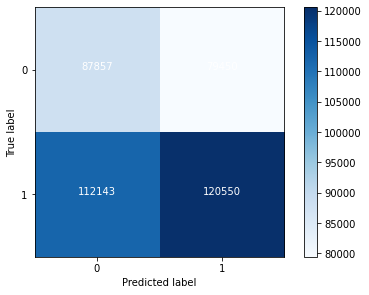

In [26]:
print("\nConfusion matrix")
conf_matrix = confusion_matrix(y_pred.round(), test_labels)
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
tick_marks = np.arange(2)   
classes = ["0","1"]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresho = conf_matrix.max() / 2.
# The below for loop helps to add numbers in the boxes
for k, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, k, conf_matrix[k, j], horizontalalignment="center", color="white" if conf_matrix[k, j] > thresho else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

ROC AUC Score : 0.5210175


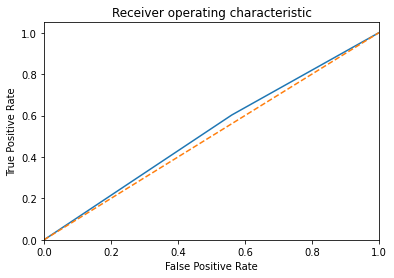

In [27]:
# Below is the ROC curve
import sklearn.metrics as m
print("ROC AUC Score : {}".format(m.roc_auc_score(test_labels, y_pred.round())))

fpr, tpr, threshold = m.roc_curve(test_labels, y_pred.round())
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()